In [2]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

The [Ornstein-Uhlenbeck process](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process) is a concept in mathematics and is described by a Stochastic Differential Equation (SDE). Simply, it's a process that tries to revert to a long-term mean value over time, with some randomness involved. 

### The Equation
$$ dX_t = \kappa (\theta - X_t) dt + \sigma dW_t $$

Here:
- $ \kappa > 0 $: Speed at which $ X_t $ reverts towards $ \theta $
- $ \theta $: The "average" or "normal" level
- $ \sigma > 0 $: Represents the randomness or "volatility"

### Key Characteristics
- **Gaussian**: The changes have a normal distribution.
- **Markovian**: Future changes depend only on the present state, not the path taken to get there.
- **Stationary**: Statistical properties like mean and variance are constant over time.

### Simplified Explanation
1. **Transform to Simpler Form**: Define $ Y_t = X_t - \theta $ to simplify the SDE to $$ dY_t = - \kappa \, Y_t \, dt + \sigma \, dW_t $$.
   
2. **Find a Solution**: Using mathematical techniques (like the Itô formula), we find that:
   $$ X_t = \theta + (X_0 - \theta)e^{-\kappa t} + \int_0^t \sigma\, e^{\kappa (s-t)} dW_s $$

### Quick Facts about $ X_t $
- **Mean (Average)**: $ \mathbb{E}[X_t] = \theta + (X_0 - \theta)e^{-\kappa t} $
- **Variance**: $ \text{Var}[X_t] = \frac{\sigma^2}{2\kappa} \left( 1- e^{-2 \kappa t} \right)$
- **Covariance**: $ \text{Cov}[X_s, X_t] = \frac{\sigma^2}{2\kappa} \left( e^{-\kappa |t-s|} - e^{-\kappa (s+t)}\, \right)$

In the long run ($ t \to \infty $), $ X_t $ tends to have a mean of $ \theta $ and a variance of $ \frac{\sigma^2}{2\kappa} $.


<a id='sec1.1'></a>
## Numerical simulation

We can discretize the SDE using the Euler-Maruyama numerical method:

$$
X_{n+1} = X_n +\kappa(\theta - X_n)\Delta t + \sigma \sqrt{\Delta t} W_n
$$

Theoretical mean=0.5 and theoretical STD=0.204124
Parameters from the fit: mean=0.499119, STD=0.200816


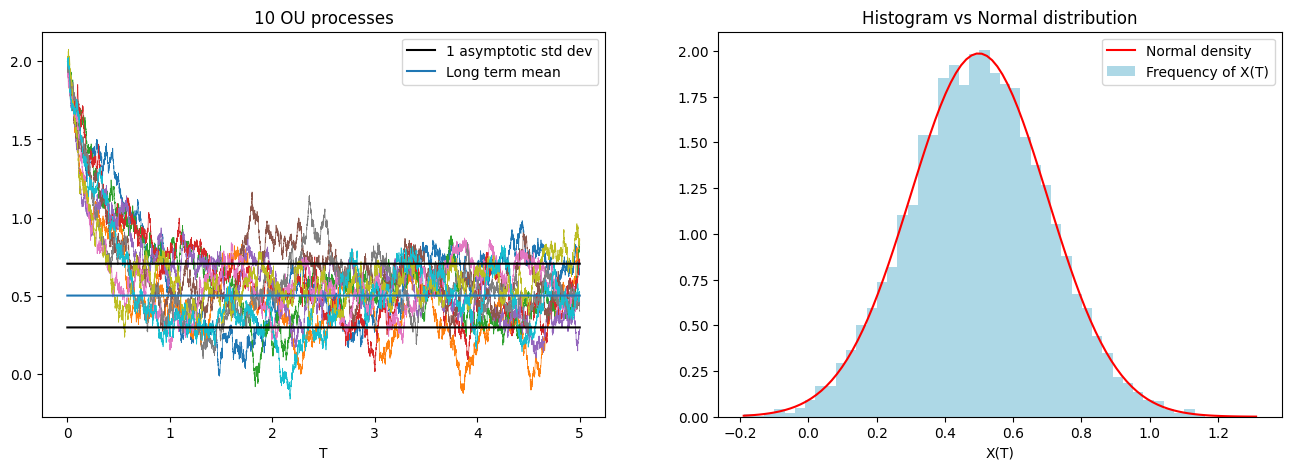

In [3]:
np.random.seed(seed=42)

N = 20000  # time steps
paths = 5000  # number of paths
T = 5
T_vec, dt = np.linspace(0, T, N, retstep=True)

kappa = 3
theta = 0.5
sigma = 0.5
std_asy = np.sqrt(sigma**2 / (2 * kappa))  # asymptotic standard deviation

X0 = 2
X = np.zeros((paths, N))
X[:, 0] = X0
W = ss.norm.rvs(loc=0, scale=1, size=(paths, N - 1))

for t in range(0,N-1):
   X[:,t+1] = X[:,t] + kappa*(theta - X[:,t])*dt + sigma * np.sqrt(dt) * W[:,t]

X_T = X[:, -1]  # values of X at time T
X_1 = X[1, :]  # a single path

mean_T = theta + np.exp(-kappa * T) * (X0 - theta)
std_T = np.sqrt(sigma**2 / (2 * kappa) * (1 - np.exp(-2 * kappa * T)))

param = ss.norm.fit(X_T)  # FIT from data
print(f"Theoretical mean={mean_T.round(6)} and theoretical STD={std_T.round(6)}")
print("Parameters from the fit: mean={0:.6f}, STD={1:.6f}".format(*param))  # these are MLE parameters

N_processes = 10  # number of processes
x = np.linspace(X_T.min(), X_T.max(), 100)
pdf_fitted = ss.norm.pdf(x, *param)

fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(T_vec, X[:N_processes, :].T, linewidth=0.5)
ax1.plot(T_vec, (theta + std_asy) * np.ones_like(T_vec), label="1 asymptotic std dev", color="black")
ax1.plot(T_vec, (theta - std_asy) * np.ones_like(T_vec), color="black")
ax1.plot(T_vec, theta * np.ones_like(T_vec), label="Long term mean")
ax1.legend(loc="upper right")
ax1.set_title(f"{N_processes} OU processes")
ax1.set_xlabel("T")
ax2.plot(x, pdf_fitted, color="r", label="Normal density")
ax2.hist(X_T, density=True, bins=50, facecolor="LightBlue", label="Frequency of X(T)")
ax2.legend()
ax2.set_title("Histogram vs Normal distribution")
ax2.set_xlabel("X(T)")
plt.show()

## **Method 2:**

Another possibility is to generate the dynamics from the solution of the SDE.     
Let us consider the solution of the OU SDE obtained above. We can compute $X_{n+1}$ and consider the initial value at time $n$.

$$ X_{n+1} = \theta + (X_n - \theta)e^{-\kappa \Delta t} + \sqrt{\frac{\sigma^2}{2\kappa} \bigl( 1- e^{-2 \kappa \Delta t} \bigr)} \; \epsilon_n $$ 

with $\epsilon_n \sim \mathcal{N}(0,1)$.

Theoretical mean=0.5 and theoretical STD=0.204124
Parameters from the fit: mean=0.499119, STD=0.200778


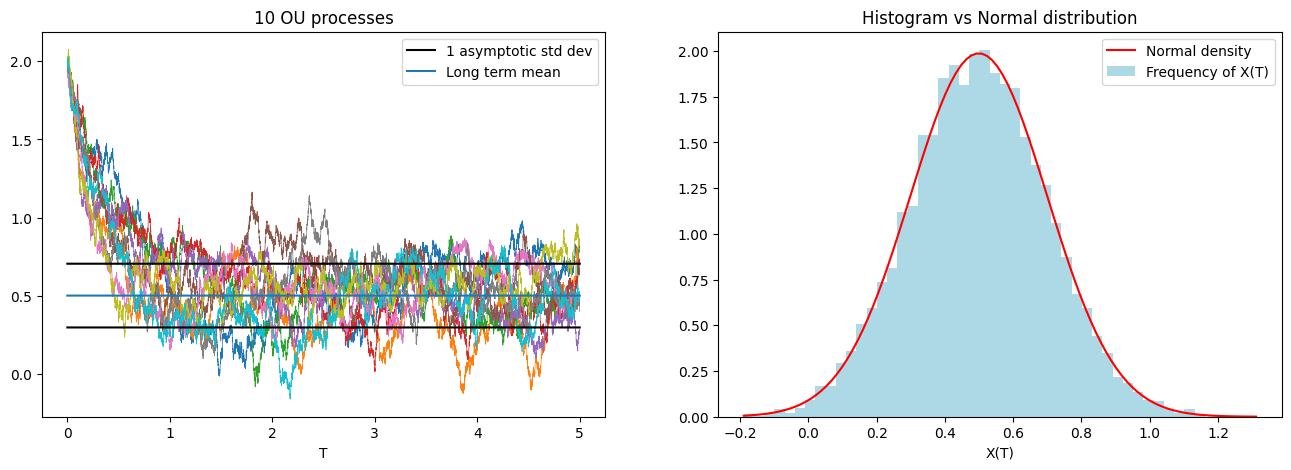

In [4]:
np.random.seed(seed=42)

N = 20000  # time steps
paths = 5000  # number of paths
T = 5
T_vec, dt = np.linspace(0, T, N, retstep=True)

kappa = 3
theta = 0.5
sigma = 0.5
std_asy = np.sqrt(sigma**2 / (2 * kappa))  # asymptotic standard deviation

X0 = 2
X = np.zeros((paths, N))
X[:, 0] = X0
W = ss.norm.rvs(loc=0, scale=1, size=(paths, N - 1))

std_dt = np.sqrt(sigma**2 / (2 * kappa) * (1 - np.exp(-2 * kappa * dt)))
for t in range(0, N - 1):
    X[:, t + 1] = theta + np.exp(-kappa * dt) * (X[:, t] - theta) + std_dt * W[:, t]

X_T = X[:, -1]  # values of X at time T
X_1 = X[1, :]  # a single path

mean_T = theta + np.exp(-kappa * T) * (X0 - theta)
std_T = np.sqrt(sigma**2 / (2 * kappa) * (1 - np.exp(-2 * kappa * T)))

param = ss.norm.fit(X_T)  # FIT from data
print(f"Theoretical mean={mean_T.round(6)} and theoretical STD={std_T.round(6)}")
print("Parameters from the fit: mean={0:.6f}, STD={1:.6f}".format(*param))  # these are MLE parameters

N_processes = 10  # number of processes
x = np.linspace(X_T.min(), X_T.max(), 100)
pdf_fitted = ss.norm.pdf(x, *param)

fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(T_vec, X[:N_processes, :].T, linewidth=0.5)
ax1.plot(T_vec, (theta + std_asy) * np.ones_like(T_vec), label="1 asymptotic std dev", color="black")
ax1.plot(T_vec, (theta - std_asy) * np.ones_like(T_vec), color="black")
ax1.plot(T_vec, theta * np.ones_like(T_vec), label="Long term mean")
ax1.legend(loc="upper right")
ax1.set_title(f"{N_processes} OU processes")
ax1.set_xlabel("T")
ax2.plot(x, pdf_fitted, color="r", label="Normal density")
ax2.hist(X_T, density=True, bins=50, facecolor="LightBlue", label="Frequency of X(T)")
ax2.legend()
ax2.set_title("Histogram vs Normal distribution")
ax2.set_xlabel("X(T)")
plt.show()

In [5]:
n1 = 4150
n2 = 5150
t1 = n1 * dt
t2 = n2 * dt

cov_th = sigma**2 / (2 * kappa) * (np.exp(-kappa * np.abs(t1 - t2)) - np.exp(-kappa * (t1 + t2)))
print(f"Theoretical COV[X(t1), X(t2)] = {cov_th.round(4)} with t1 = {t1.round(4)} and t2 = {t2.round(4)}")
print(f"Computed covariance from data COV[X(t1), X(t2)] = {np.cov( X[:,n1], X[:,n2] )[0,1].round(4)}")

Theoretical COV[X(t1), X(t2)] = 0.0196 with t1 = 1.0376 and t2 = 1.2876
Computed covariance from data COV[X(t1), X(t2)] = 0.0198


<a id='sec1.2'></a>
## Estimation of parameters from a single path

### Least squares estimation

We can compute $X_{t+\Delta t}$ and consider the initial value at time $t$.

$$ \begin{aligned}
X_{t+\Delta t} &= \theta + (X_t - \theta)e^{-\kappa \Delta t} + \int_t^{t+\Delta t} \sigma\, e^{\kappa (s-t)} dW_s \\
               &= \theta \bigl( 1-e^{-\kappa \Delta t} \bigr) + e^{-\kappa \Delta t} X_t + \int_t^{t+\Delta t} \sigma\, e^{\kappa (s-t)} dW_s \\
               &= \alpha + \beta X_t + \epsilon_t
\end{aligned} $$

where $\alpha = \theta \bigl( 1-e^{-\kappa \Delta t} \bigr)$, $\beta = e^{-\kappa \Delta t}$ and with $\epsilon_t \sim \mathcal{N}\biggl( 0, \frac{\sigma^2}{2\kappa} \bigl( 1- e^{-2 \kappa \Delta t} \bigr)\biggr)$.

So, let us use the usual OLS method to estimate $\alpha$, $\beta$ and $\sigma$.
Then, we can obtain the parameters from the formulas:

$$ \kappa = - \frac{\log \beta}{\Delta t}, \quad \theta = \frac{\alpha}{1-\beta}, \quad 
\sigma = \text{Std}[\epsilon_t] \sqrt{ \frac{2\kappa}{1-\beta^2} }$$

In [6]:
XX = X_1[:-1]
YY = X_1[1:]
beta, alpha, _, _, _ = ss.linregress(XX, YY)  # OLS
kappa_ols = -np.log(beta) / dt
theta_ols = alpha / (1 - beta)
res = YY - beta * XX - alpha  # residuals
std_resid = np.std(res, ddof=2)
sig_ols = std_resid * np.sqrt(2 * kappa_ols / (1 - beta**2))

print("OLS theta = ", theta_ols)
print("OLS kappa = ", kappa_ols)
print("OLS sigma = ", sig_ols)

OLS theta =  0.40273215093892223
OLS kappa =  3.4448221867780426
OLS sigma =  0.49904604497283017


### Maximum Likelihood Estimation

We know that 
$$ X_{i+1} \sim \mathcal{N}\biggl( \theta \bigl( 1-e^{-\kappa \Delta t} \bigr) + e^{-\kappa \Delta t} X_i \, , \, \frac{\sigma^2}{2\kappa} \bigl( 1- e^{-2 \kappa \Delta t} \bigr)\biggr)$$

Let us define $\hat \sigma^2 := \frac{\sigma^2}{2\kappa} \bigl( 1- e^{-2 \kappa \Delta t} \bigr)$.

At this point it is possible to write the log-likelihood function and impose the condition that first order derivatives are equal to zero. All these steps are done in [1]. 
Here I just recall the final formulas:

$$ S_x = \sum_{i=1}^n X_{i-1} \quad S_y = \sum_{i=1}^n X_{i} \quad S_{xx} = \sum_{i=1}^n X_{i-1}^2 
\quad S_{xy} = \sum_{i=1}^n X_{i-1}X_{i} \quad S_{yy} = \sum_{i=1}^n X_{i}^2$$

The parameters are:

$$ \theta = \frac{S_y S_{xx} - S_x S_{xy}}{n(S_{xx}-S_{xy}) - (S_{x}^2 - S_{x} S_{y})} $$

$$ \kappa = - \frac{1}{\Delta t} \log \frac{S_{xy} - \theta S_{x} - \theta S_{y} +n\theta^2}{S_{xx} - 2\theta S_{x} +n \theta^2} $$

$$ 
\hat \theta^2 = \frac{1}{n} \biggl[ S_{yy} -2e^{-\kappa \Delta t} S_{xy} 
+ e^{-2 \kappa \Delta t} S{xx} -2\theta(1-e^{- \kappa \Delta t})(S_y - e^{- \kappa \Delta t}S_x) 
+n \theta^2(1-e^{- \kappa \Delta t})^2 \biggr] $$
$$ \sigma^2 = \hat \theta^2 \frac{2\kappa}{1-e^{-2 \kappa \Delta t}} $$

In [7]:
Sx = np.sum(XX)
Sy = np.sum(YY)
Sxx = XX @ XX
Sxy = XX @ YY
Syy = YY @ YY

theta_mle = (Sy * Sxx - Sx * Sxy) / (N * (Sxx - Sxy) - (Sx**2 - Sx * Sy))
kappa_mle = -(1 / dt) * np.log(
    (Sxy - theta_mle * Sx - theta_mle * Sy + N * theta_mle**2) / (Sxx - 2 * theta_mle * Sx + N * theta_mle**2)
)
sigma2_hat = (
    Syy
    - 2 * np.exp(-kappa_mle * dt) * Sxy
    + np.exp(-2 * kappa_mle * dt) * Sxx
    - 2 * theta_mle * (1 - np.exp(-kappa_mle * dt)) * (Sy - np.exp(-kappa_mle * dt) * Sx)
    + N * theta_mle**2 * (1 - np.exp(-kappa_mle * dt)) ** 2
) / N
sigma_mle = np.sqrt(sigma2_hat * 2 * kappa_mle / (1 - np.exp(-2 * kappa_mle * dt)))

In [8]:
print("theta MLE = ", theta_mle)
print("kappa MLE = ", kappa_mle)
print("sigma MLE = ", sigma_mle)

theta MLE =  0.4027057610190362
kappa MLE =  3.44449612124427
sigma MLE =  0.4990086188859094


With the MLE we obtain parameters quite similar to those obtained by OLS.